# Treeflow example - carnivores data

Dataset from **Suchard, Marc A., and Andrew Rambaut. "Many-core algorithms for statistical phylogenetics." *Bioinformatics* 25.11 (2009): 1370-1376.**

Sequences accessed from [Beast examples on Github](https://github.com/beast-dev/beast-mcmc/blob/v1.10.4/examples/Benchmarks/benchmark2.xml).

In [1]:
import treeflow

2022-10-30 22:20:18.645538: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/christiaan/lib:
2022-10-30 22:20:18.645554: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Read input data

In [2]:
tree = treeflow.convert_tree_to_tensor(treeflow.parse_newick("demo-data/carnivores.newick"))
tree.node_heights

2022-10-30 22:20:20.305099: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 22:20:20.305339: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/christiaan/lib:
2022-10-30 22:20:20.305398: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/christiaan/lib:
2022-10-30 22:20:20.305427: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PA

<tf.Tensor: shape=(61,), dtype=float64, numpy=
array([0.05845 , 0.07205 , 0.08652 , 0.047   , 0.06448 , 0.08533 ,
       0.12308 , 0.30126 , 0.03246 , 0.05344 , 0.05663 , 0.01815 ,
       0.08589 , 0.08867 , 0.10523 , 0.03805 , 0.01402 , 0.01425 ,
       0.00839 , 0.0166  , 0.01789 , 0.05223 , 0.06599 , 0.11039 ,
       0.15421 , 0.0116  , 0.03125 , 0.04048 , 0.04165 , 0.04424 ,
       0.04595 , 0.03913 , 0.05364 , 0.09306 , 0.20766 , 0.25459 ,
       0.12729 , 0.15951 , 0.02638 , 0.10512 , 0.16417 , 0.17777 ,
       0.19941 , 0.32409 , 0.12283 , 0.35432 , 0.36806 , 0.38553 ,
       0.04165 , 0.04812 , 0.00993 , 0.05352 , 0.06244 , 0.14523 ,
       0.19857 , 0.385531, 0.02982 , 0.05469 , 0.16975 , 0.45712 ,
       0.46942 ])>

In [3]:
alignment = treeflow.Alignment("demo-data/carnivores.fasta").get_compressed_alignment()
alignment

WeightedAlignment(taxon_count=62, pattern_count=5565)

## Model specification

### Single kappa parameter across tree

In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
from treeflow import float_constant as c
from treeflow.evolution.substitution import HKY, get_transition_probabilities_tree
from tensorflow_probability.python.distributions import (
    JointDistributionNamed,
    Gamma,
    LogNormal,
    Dirichlet
)
from treeflow.distributions import (
    DiscretizedDistribution,
    DiscreteParameterMixture,
    LeafCTMC,
    SampleWeighted,
    Yule
)


site_category_count = 4
pattern_counts = alignment.get_weights_tensor()
subst_model = HKY()

def build_sequence_dist(tree, kappa, frequencies, site_gamma_shape):
    unrooted_tree = tree.get_unrooted_tree()
    site_rate_distribution = DiscretizedDistribution(
        category_count=site_category_count,
        distribution=Gamma(concentration=site_gamma_shape, rate=site_gamma_shape),
    )
    transition_probs_tree = get_transition_probabilities_tree(
        unrooted_tree,
        subst_model,
        rate_categories=site_rate_distribution.normalised_support,
        frequencies=frequencies,
        kappa=kappa
    )
    return SampleWeighted(
        DiscreteParameterMixture(
            site_rate_distribution,
            LeafCTMC(
                transition_probs_tree,
                tf.expand_dims(frequencies, -2),
            ),
        ),
        sample_shape=alignment.site_count,
        weights=pattern_counts
    )
    

base_model = tfp.distributions.JointDistributionNamed(dict(
    birth_rate=LogNormal(c(1.0), c(1.5)),
    tree=lambda birth_rate: Yule(tree.taxon_count, birth_rate, name="tree"),
    kappa=LogNormal(c(0.0), c(2.0)),
    site_gamma_shape=LogNormal(c(0.0), c(1.0)),
    frequencies=Dirichlet(c([2.0, 2.0, 2.0, 2.0])),
    sequences=build_sequence_dist
))
base_model_pinned = base_model.experimental_pin(sequences=alignment.get_encoded_sequence_tensor(tree.taxon_set))
prior_samples = base_model_pinned.sample_unpinned()
prior_samples.keys()

/home/christiaan/uni/treeflow/treeflow/distributions/tree/birthdeath/birth_death_contemporary_sampling.py:69: UserWarning: Dummy sampling
  warnings.warn("Dummy sampling")
/home/christiaan/uni/treeflow/treeflow/tf_util/attrs.py:7: UserWarning: Temporary hotfix
  warnings.warn("Temporary hotfix")


/home/christiaan/uni/treeflow/treeflow/distributions/leaf_ctmc.py:62: UserWarning: Dummy sampling of alignment
  warnings.warn("Dummy sampling of alignment")


dict_keys(['birth_rate', 'tree', 'site_gamma_shape', 'kappa', 'frequencies'])

#### Variational inference

/home/christiaan/uni/treeflow/treeflow/tf_util/attrs.py:7: UserWarning: Temporary hotfix
  warnings.warn("Temporary hotfix")
2022-10-30 22:20:21.930736: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


  0%|          | 0/30000 [00:00<?, ?it/s]

CPU times: user 14h 13min 16s, sys: 37min 28s, total: 14h 50min 45s
Wall time: 1h 20min 13s


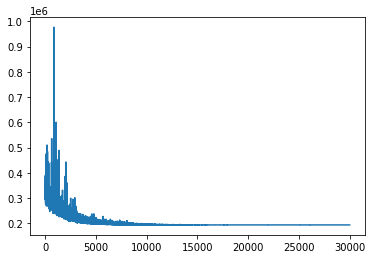

In [5]:
%%time
from treeflow.vi import fit_fixed_topology_variational_approximation, RobustOptimizer
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

optimizer = RobustOptimizer(tf.optimizers.Adam(learning_rate=0.001))
num_steps = 30000
base_approx, (base_loss, base_vars) = fit_fixed_topology_variational_approximation(
    base_model_pinned,
    topologies=dict(tree=tree.topology),
    optimizer=optimizer,
    num_steps=num_steps,
    init_loc=dict(tree=tree),
    progress_bar=tqdm
)
plt.plot(base_loss)

##### Check for parameters convergence

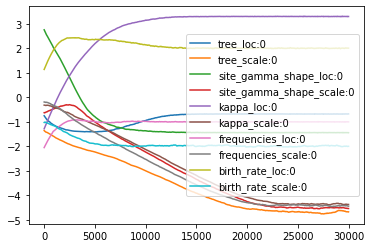

In [6]:
for varname, value in base_vars.items():
    np_value = value.numpy()
    if len(np_value.shape) > 1:
        np_value = np_value[:, -1]
    plt.plot(np_value, label=varname)
plt.legend()

##### Estimated kappa

/home/christiaan/uni/treeflow/treeflow/distributions/tree/birthdeath/birth_death_contemporary_sampling.py:69: UserWarning: Dummy sampling
  warnings.warn("Dummy sampling")


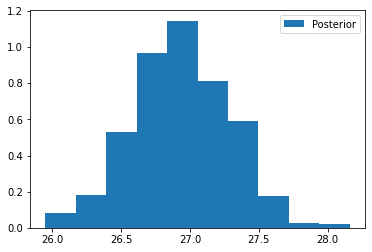

In [7]:
n_samples = 1000
base_samples = base_approx.sample(n_samples)
prior_samples = base_model_pinned.sample_unpinned(n_samples)

plt.hist(base_samples["kappa"].numpy(), label="Posterior", density=True)
plt.legend()

##### Tree height

(array([  3.,  19.,  65., 149., 252., 227., 184.,  78.,  21.,   2.]),
 array([0.49031042, 0.49342678, 0.49654314, 0.4996595 , 0.50277586,
        0.50589223, 0.50900859, 0.51212495, 0.51524131, 0.51835767,
        0.52147404]),
 <BarContainer object of 10 artists>)

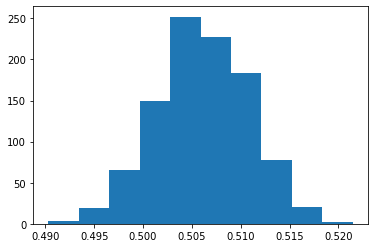

In [8]:
plt.hist(base_samples["tree"].node_heights[:, -1].numpy())

In [9]:
from treeflow.tree.io import write_tensor_trees
from treeflow.model.io import write_samples_to_file

base_out_samples = dict(base_samples)
base_tree_samples = base_out_samples.pop("tree")
write_tensor_trees(
    "demo-data/carnivores.newick", base_tree_samples.branch_lengths, "demo-out/carnivores-base-trees.nexus"
)
write_samples_to_file(
    base_samples,
    base_model_pinned,
    "demo-out/carnivores-base-samples.csv",
    vars=base_out_samples.keys(), tree_vars=dict(tree=base_tree_samples)
)

### Per site kappa parameter

In [10]:
def build_sequence_dist_alt(tree, kappa, frequencies, site_gamma_shape):
    # kappa has shape (..., n_branches)
    unrooted_tree = tree.get_unrooted_tree()
    site_rate_distribution = DiscretizedDistribution(
        category_count=site_category_count,
        distribution=tfp.distributions.Gamma(concentration=site_gamma_shape, rate=site_gamma_shape),
    )
    frequencies_b = tf.broadcast_to(tf.expand_dims(frequencies, -2), kappa.shape + (4,))
    transition_probs_tree = get_transition_probabilities_tree(
        unrooted_tree,
        subst_model,
        rate_categories=site_rate_distribution.normalised_support,
        frequencies=frequencies_b,
        kappa=kappa,
        inner_batch_rank=1,
        batch_rank=-1 # Don't add a batch dimension for branches
    )
    return SampleWeighted(
        DiscreteParameterMixture(
            site_rate_distribution,
            LeafCTMC(
                transition_probs_tree,
                tf.expand_dims(frequencies, -2),
            ),
        ),
        sample_shape=alignment.site_count,
        weights=pattern_counts
    )
alt_model = tfp.distributions.JointDistributionNamed(dict(
    birth_rate=tfp.distributions.LogNormal(c(1.0), c(1.5)),
    tree=lambda birth_rate: treeflow.distributions.Yule(tree.taxon_count, birth_rate, name="tree"),
    kappa=tfp.distributions.Sample(tfp.distributions.LogNormal(c(0.0), c(2.0)), tree.branch_lengths.shape),
    site_gamma_shape=tfp.distributions.LogNormal(c(0.0), c(1.0)),
    frequencies=tfp.distributions.Dirichlet(c([2.0, 2.0, 2.0, 2.0])),
    sequences=build_sequence_dist_alt
))
alt_model_pinned = alt_model.experimental_pin(sequences=alignment.get_encoded_sequence_tensor(tree.taxon_set))
prior_samples = alt_model_pinned.sample_unpinned()
prior_samples.keys()

/home/christiaan/uni/treeflow/treeflow/distributions/leaf_ctmc.py:62: UserWarning: Dummy sampling of alignment
  warnings.warn("Dummy sampling of alignment")


dict_keys(['birth_rate', 'tree', 'site_gamma_shape', 'kappa', 'frequencies'])

  0%|          | 0/30000 [00:00<?, ?it/s]

CPU times: user 14h 29min 13s, sys: 31min 8s, total: 15h 22s
Wall time: 1h 20min 59s


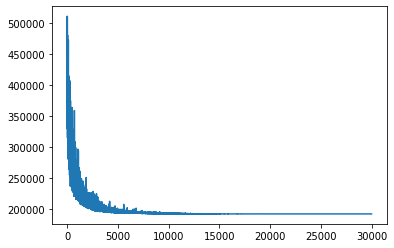

In [11]:
%%time
alt_approx, alt_trace = fit_fixed_topology_variational_approximation(
    alt_model_pinned,
    topologies=dict(tree=tree.topology),
    optimizer=optimizer,
    num_steps=num_steps,
    progress_bar=tqdm
)
plt.plot(alt_trace.loss)

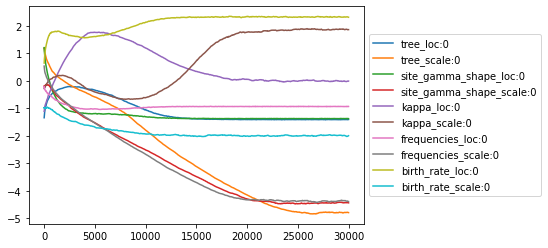

In [12]:
for varname, value in alt_trace.parameters.items():
    np_value = value.numpy()
    if len(np_value.shape) > 1:
        np_value = np_value[:, -1]
    plt.plot(np_value, label=varname)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

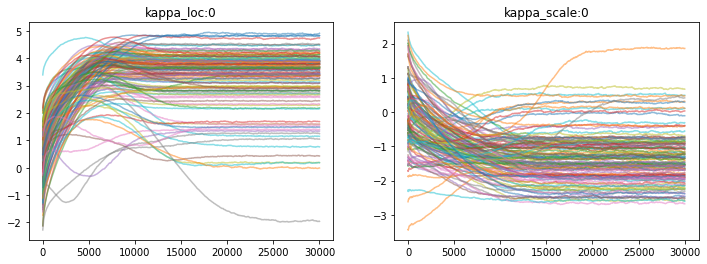

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
for ax, varname in zip(axs, ["kappa_loc:0", "kappa_scale:0"]):
    ax.plot(alt_trace.parameters[varname].numpy(), alpha=0.5)
    ax.set_title(varname)

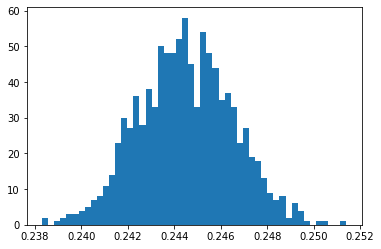

In [14]:
alt_samples = alt_approx.sample(n_samples)
plt.hist(alt_samples["tree"].node_heights[:, -1].numpy(), bins=50);

In [15]:
alt_out_samples = dict(alt_samples)
alt_tree_samples = alt_out_samples.pop("tree")
write_tensor_trees(
    "demo-data/carnivores.newick",
    alt_tree_samples.branch_lengths,
    "demo-out/carnivores-alt-trees.nexus",
    branch_metadata=dict(kappa=alt_out_samples["kappa"])
)
write_samples_to_file(
    alt_samples, alt_model_pinned, "demo-out/carnivores-alt-samples.csv", vars=alt_out_samples.keys()
)

### Model comparison with marginal likelihood
The negative of the loss (the *evidence lower bound*) can be interpreted a lower bound on the marginal likelihood of the model given the data and can be used for model selection; the data shows a preference for the model with the higher marginal likelihood.

In [21]:
alt_loss = alt_trace.loss
[-tf.reduce_mean(x[-100:]) for x in [base_loss, alt_loss]]

[<tf.Tensor: shape=(), dtype=float64, numpy=-193623.18821953292>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-192424.5419144597>]

We can use importance sampling and the final fitted variational distribution to improve this estimate.

In [20]:
import yaml
from treeflow.vi import estimate_log_ml_importance_sampling

ml_n_samples = 100
base_ml_result = estimate_log_ml_importance_sampling(base_model_pinned, base_approx, vectorize_log_prob=False, n_samples=ml_n_samples)
alt_ml_result = estimate_log_ml_importance_sampling(alt_model_pinned, alt_approx, vectorize_log_prob=False, n_samples=ml_n_samples)

marginal_likelihood_dict = dict(
    base=base_ml_result.numpy(),
    lineage_variation=alt_ml_result.numpy()
)

with open("demo-out/carnivores-marginal-log-likelihoods.yaml", "w") as f:
    yaml.dump(marginal_likelihood_dict, f)
    
marginal_likelihood_dict

/home/christiaan/uni/treeflow/treeflow/tf_util/attrs.py:7: UserWarning: Temporary hotfix
  warnings.warn("Temporary hotfix")


Exception ignored in: <bound method WeakStructRef._cleanup of WeakStructRef({'birth_rate': HashableWeakRef(<weakref at 0x7fdcad26b360; to 'Tensor' at 0x7fdcad422100>), 'tree': HashableWeakRef(<weakref at 0x7fdcad26b4a0; dead>), 'site_gamma_shape': HashableWeakRef(<weakref at 0x7fdcad26b450; to 'Tensor' at 0x7fdcad422760>), 'kappa': HashableWeakRef(<weakref at 0x7fdcad26b400; dead>), 'frequencies': HashableWeakRef(<weakref at 0x7fdcad26b3b0; to 'Tensor' at 0x7fdcad4223a0>)})>
Traceback (most recent call last):
  File "/home/christiaan/.pyenv/versions/3.8.13/envs/treeflow/lib/python3.8/site-packages/tensorflow_probability/python/internal/cache_util.py", line 151, in _cleanup
    self._callback(self)
  File "/home/christiaan/.pyenv/versions/3.8.13/envs/treeflow/lib/python3.8/site-packages/tensorflow_probability/python/internal/cache_util.py", line 221, in maybe_del
    del self[key]
KeyError: WeakStructRef({'birth_rate': HashableWeakRef(<weakref at 0x7fdcad26b360; to 'Tensor' at 0x7fdcad4

Exception ignored in: <bound method WeakStructRef._cleanup of WeakStructRef({'birth_rate': HashableWeakRef(<weakref at 0x7fdcad2ee770; to 'Tensor' at 0x7fdcad4aa6d0>), 'tree': HashableWeakRef(<weakref at 0x7fdcad2ee8b0; dead>), 'site_gamma_shape': HashableWeakRef(<weakref at 0x7fdcad2ee860; to 'Tensor' at 0x7fdcad4aa2e0>), 'kappa': HashableWeakRef(<weakref at 0x7fdcad2ee810; dead>), 'frequencies': HashableWeakRef(<weakref at 0x7fdcad2ee7c0; to 'Tensor' at 0x7fdcad4aaac0>)})>
Traceback (most recent call last):
  File "/home/christiaan/.pyenv/versions/3.8.13/envs/treeflow/lib/python3.8/site-packages/tensorflow_probability/python/internal/cache_util.py", line 151, in _cleanup
    self._callback(self)
  File "/home/christiaan/.pyenv/versions/3.8.13/envs/treeflow/lib/python3.8/site-packages/tensorflow_probability/python/internal/cache_util.py", line 221, in maybe_del
    del self[key]
KeyError: WeakStructRef({'birth_rate': HashableWeakRef(<weakref at 0x7fdcad2ee770; to 'Tensor' at 0x7fdcad4

{'base': -193606.43804341275, 'lineage_variation': -192414.3959204308}

We observe that the data shows a preference for the model with variation of the kappa parameter between lineages. 

### Visualisation of estimated kappa parameters

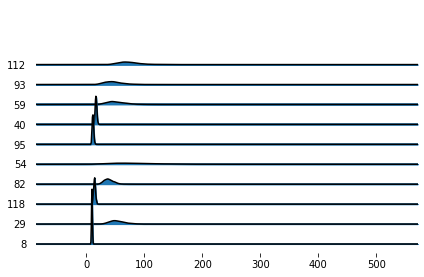

In [26]:
import joypy
import numpy as np
import pandas as pd

kappa_df = pd.DataFrame(alt_samples["kappa"].numpy())
n_columns = 10
columns = np.random.choice(kappa_df.columns, n_columns, replace=False)
joypy.joyplot(kappa_df[columns]);

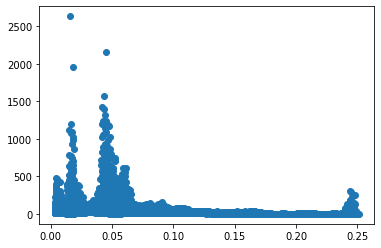

In [23]:
alt_trees = alt_samples["tree"]
parent_indices = alt_trees.topology.parent_indices
parent_indices_b = tf.broadcast_to(parent_indices, alt_trees.heights.shape[:1] + parent_indices.shape)
branch_centre = (tf.gather(alt_trees.heights, parent_indices_b, batch_dims=1) + alt_trees.heights[..., :-1]) / 2.0
plt.scatter(branch_centre.numpy(), alt_samples["kappa"].numpy())

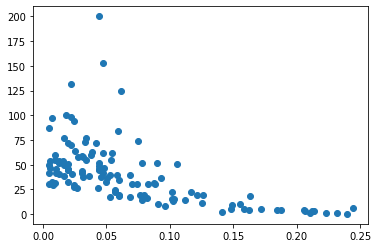

In [24]:
plt.scatter(branch_centre.numpy().mean(axis=0), alt_samples["kappa"].numpy().mean(axis=0))

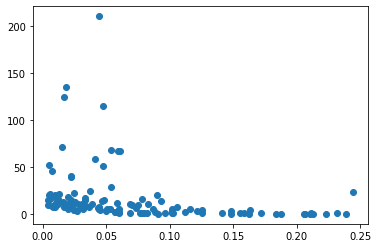

In [25]:
plt.scatter(branch_centre.numpy().mean(axis=0), alt_samples["kappa"].numpy().std(axis=0))